In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision
import numpy as np
from tqdm import tqdm
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [2]:
train_metadata = torchvision.datasets.MNIST(root='./data', train=True, download=True)
test_metadata = torchvision.datasets.MNIST(root='./data', train=False, download=True)

train_x = train_metadata.data[:50000].unsqueeze(1) / 255
val_x = train_metadata.data[-10000:].unsqueeze(1) / 255
test_x = test_metadata.data.unsqueeze(1) / 255
train_y = train_metadata.targets[:50000]
val_y = train_metadata.targets[-10000:]
test_y = test_metadata.targets

In [3]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
# DEVICE = 'cpu'
BATCH_SIZE = 256
NUM_TRAIN = 50000
NUM_VAL = 10000
IMG_C = train_x.shape[-3]
IMG_H = train_x.shape[-2]
IMG_W = train_x.shape[-1]

train_data = TensorDataset(train_x, train_y)
val_data = TensorDataset(val_x, val_y)
test_data = TensorDataset(test_x, test_y)

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE)

In [4]:
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        self.encode = nn.Sequential(
          nn.Conv2d(input_dim, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2),

          nn.Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2),

          nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2),

          nn.Flatten()
        )
        self.fc_mu = nn.Linear(128 * 3 * 3, latent_dim)
        self.fc_var = nn.Linear(128 * 3 * 3, latent_dim)

    def forward(self, x):
        encoded = self.encode(x)
        mu = self.fc_mu(encoded)
        log_var = self.fc_var(encoded)
        z = self.reparameterization(mu, log_var)
        return z, mu, log_var

    def reparameterization(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        epsilon = torch.randn_like(std).to(DEVICE)
        z = mu + std * epsilon
        return z

class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Decoder, self).__init__()
        self.decode = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 128, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1)),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(32, output_dim, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1)),
            nn.Flatten()
        )
        self.fc_probs = nn.Linear(31 * 31, IMG_H * IMG_W)

    def forward(self, x):
        x = x.unsqueeze(-1).unsqueeze(-1)
        x = self.decode(x)
        probs = torch.sigmoid(self.fc_probs(x))
        return probs

class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        z, mu_z, log_var_z = self.encoder(x)
        probs_x = self.decoder(z)
        return mu_z, log_var_z, probs_x

    def reconstruct(self, probs_x):
        bern_dist = torch.distributions.Bernoulli(probs_x)
        x_recon = bern_dist.sample()
        return x_recon.view(x_recon.shape[0], IMG_C, IMG_H, IMG_W)

In [5]:
LATENT_DIM = 16

encoder = Encoder(input_dim=IMG_C, latent_dim=LATENT_DIM)
decoder = Decoder(latent_dim=LATENT_DIM, output_dim=IMG_C)
vae = VAE(encoder, decoder).to(DEVICE)
print(vae)

VAE(
  (encoder): Encoder(
    (encode): Sequential(
      (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (9): Flatten(start_dim=1, end_dim=-1)
    )
    (fc_mu): Linear(in_features=1152, out_features=16, bias=True)
    (fc_var): Linear(in_features=1152, out_features=16, bias=True)
  )
  (decoder): Decoder(
    (decode): Sequential(
      (0): ConvTranspose2d(16, 128, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentu

  5%|▌         | 1/20 [00:07<02:23,  7.56s/it]

Epoch 1, Mean Training ELBO 200.51982, Mean Validation ELBO 173.71348481445312


 10%|█         | 2/20 [00:13<01:56,  6.48s/it]

Epoch 2, Mean Training ELBO 142.39175017578125, Mean Validation ELBO 126.41007648925782


 15%|█▌        | 3/20 [00:19<01:44,  6.14s/it]

Epoch 3, Mean Training ELBO 118.75851607421875, Mean Validation ELBO 116.91995020751953


 20%|██        | 4/20 [00:24<01:35,  5.98s/it]

Epoch 4, Mean Training ELBO 111.58811927734375, Mean Validation ELBO 111.22998858642578


 25%|██▌       | 5/20 [00:30<01:28,  5.91s/it]

Epoch 5, Mean Training ELBO 108.1671506640625, Mean Validation ELBO 109.24222521972656


 30%|███       | 6/20 [00:36<01:22,  5.86s/it]

Epoch 6, Mean Training ELBO 106.1348048828125, Mean Validation ELBO 107.60910505371093


 35%|███▌      | 7/20 [00:42<01:16,  5.85s/it]

Epoch 7, Mean Training ELBO 104.89175142578125, Mean Validation ELBO 106.4602547241211


 40%|████      | 8/20 [00:47<01:10,  5.83s/it]

Epoch 8, Mean Training ELBO 103.915874921875, Mean Validation ELBO 104.94382917480469


 45%|████▌     | 9/20 [00:53<01:04,  5.83s/it]

Epoch 9, Mean Training ELBO 102.88605515625, Mean Validation ELBO 103.60356749267578


 50%|█████     | 10/20 [00:59<00:58,  5.83s/it]

Epoch 10, Mean Training ELBO 102.558390625, Mean Validation ELBO 102.69211785888672


 55%|█████▌    | 11/20 [01:05<00:52,  5.83s/it]

Epoch 11, Mean Training ELBO 101.8551784375, Mean Validation ELBO 102.49770249023437


 60%|██████    | 12/20 [01:11<00:46,  5.84s/it]

Epoch 12, Mean Training ELBO 101.26429201171875, Mean Validation ELBO 103.08937796630859


 65%|██████▌   | 13/20 [01:17<00:40,  5.85s/it]

Epoch 13, Mean Training ELBO 101.02132279296875, Mean Validation ELBO 101.94179097900391


 70%|███████   | 14/20 [01:23<00:35,  5.86s/it]

Epoch 14, Mean Training ELBO 100.31798380859375, Mean Validation ELBO 101.86073562011718


 75%|███████▌  | 15/20 [01:28<00:29,  5.85s/it]

Epoch 15, Mean Training ELBO 100.04366650390625, Mean Validation ELBO 102.09755544433594


 80%|████████  | 16/20 [01:34<00:23,  5.86s/it]

Epoch 16, Mean Training ELBO 99.86883190429687, Mean Validation ELBO 102.7555697265625


 85%|████████▌ | 17/20 [01:40<00:17,  5.86s/it]

Epoch 17, Mean Training ELBO 99.605878359375, Mean Validation ELBO 102.60977067871094


 90%|█████████ | 18/20 [01:46<00:11,  5.86s/it]

Epoch 18, Mean Training ELBO 99.36705385742188, Mean Validation ELBO 101.57463530273438


 95%|█████████▌| 19/20 [01:52<00:05,  5.86s/it]

Epoch 19, Mean Training ELBO 99.00961752929688, Mean Validation ELBO 100.84609919433593


100%|██████████| 20/20 [01:58<00:00,  5.91s/it]

Epoch 20, Mean Training ELBO 98.65775134765624, Mean Validation ELBO 101.12871247558594


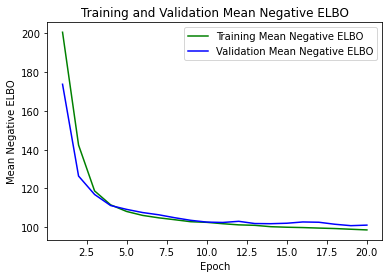

In [6]:
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

def train_vae(num_epochs, patience=5):
    train_elbos = []
    val_elbos = []
    best_val_elbo = np.inf
    tolerance = 0
    epochs = num_epochs
    for epoch in tqdm(range(num_epochs)):
        overall_train_elbo = 0.0
        overall_val_elbo = 0.0
        for batch in train_dataloader:
            optimizer.zero_grad()
            x, _ = batch
            x = x.to(DEVICE)
            mu_z, log_var_z, probs_x = vae(x)
            x = torch.flatten(x, start_dim=1)
            log_p = -F.binary_cross_entropy(probs_x, x, reduction='sum')
            kl = -0.5 * torch.sum(1 + log_var_z - mu_z.pow(2) - log_var_z.exp())
            negative_elbo = -log_p + kl
            negative_elbo.backward()
            optimizer.step()
            overall_train_elbo += negative_elbo.item()

        for batch in val_dataloader:
            x, _ = batch
            x = x.to(DEVICE)
            with torch.no_grad():
                mu_z, log_var_z, probs_x = vae(x)
                x = torch.flatten(x, start_dim=1)
                log_p = -F.binary_cross_entropy(probs_x, x, reduction='sum')
                kl = -0.5 * torch.sum(1 + log_var_z - mu_z.pow(2) - log_var_z.exp())
                negative_elbo = -log_p + kl
                overall_val_elbo += negative_elbo.item()
        mean_train_elbo = overall_train_elbo / NUM_TRAIN
        mean_val_elbo = overall_val_elbo / NUM_VAL
        print('Epoch {}, Mean Training ELBO {}, Mean Validation ELBO {}'.format(epoch + 1, mean_train_elbo, mean_val_elbo))
        train_elbos.append(mean_train_elbo)
        val_elbos.append(mean_val_elbo)
        if mean_val_elbo < best_val_elbo:
            best_val_elbo = mean_val_elbo
            tolerance = 0
        else:
            tolerance += 1
            if tolerance == patience:
                print('Early Stopped!')
                epochs = epoch + 1
                break
    plt.plot(range(1, epochs + 1), train_elbos, 'g', label='Training Mean Negative ELBO')
    plt.plot(range(1, epochs + 1), val_elbos, 'b', label='Validation Mean Negative ELBO')
    plt.title('Training and Validation Mean Negative ELBO')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Negative ELBO')
    plt.legend()
    plt.show()
train_vae(num_epochs=20)

In [7]:
def test_vae():
    x, _ = next(iter(test_dataloader))
    x = x.to(DEVICE)
    with torch.no_grad():
        _, _, probs_x = vae(x)
        x_recon = vae.reconstruct(probs_x)
        # x_recon = probs_x
        return x, x_recon
test_batch, test_batch_recon = test_vae()

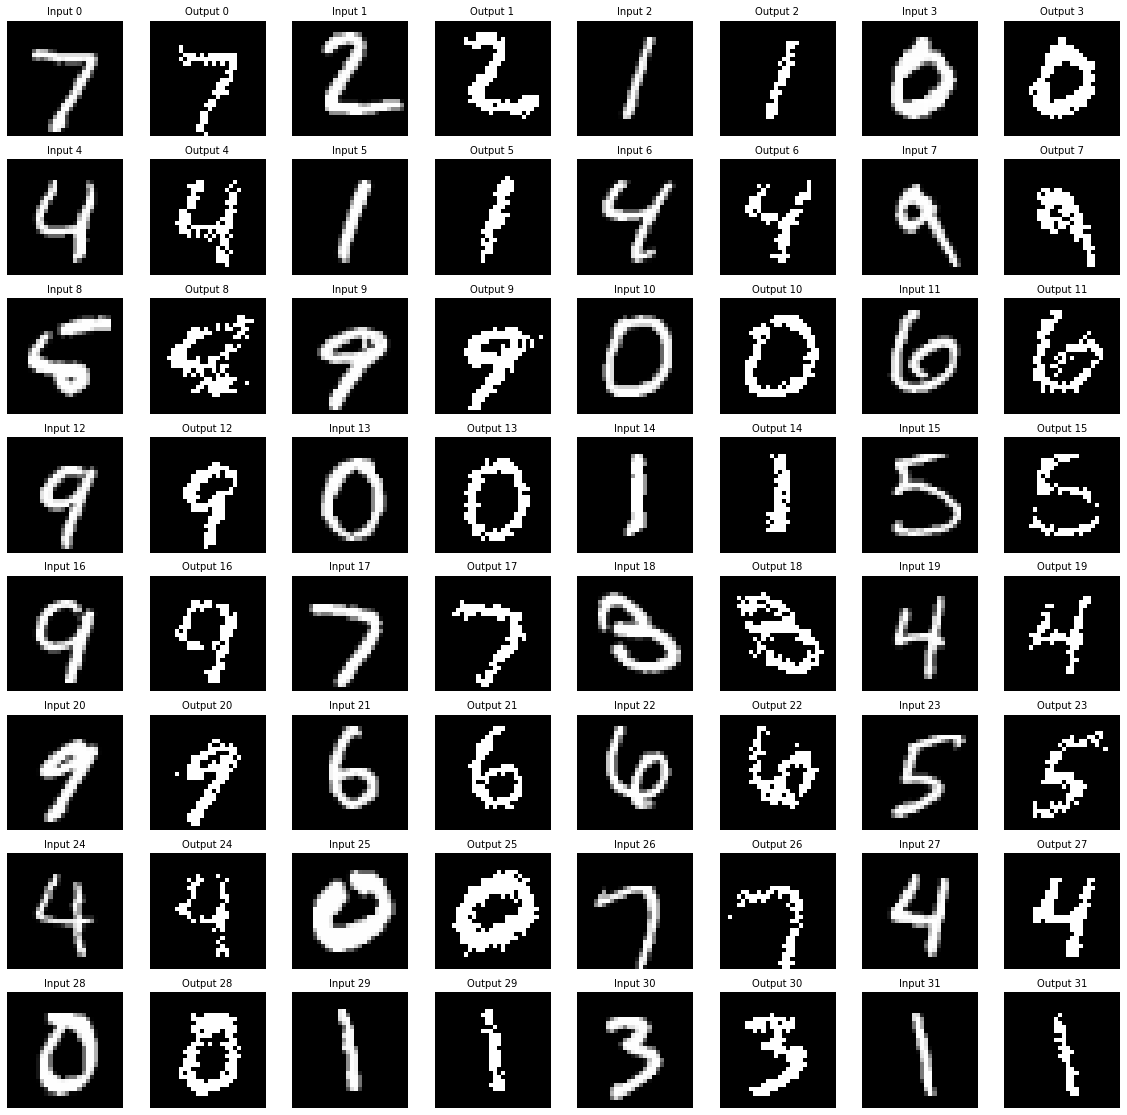

In [8]:
def show_images(x, x_recon):
    """ plots first 32 images and reconstructions"""
    x = x.view(BATCH_SIZE, 28, 28)
    x_recon = x_recon.view(BATCH_SIZE, 28, 28)
    fig, ax = plt.subplots(8, 8, figsize=(20, 20))
    for i in range(8):
        for j in range(4):
            ax[i][2*j].imshow(x[i*4+j].cpu().numpy(), cmap="Greys_r")
            ax[i][2*j+1].imshow(x_recon[i*4+j].cpu().numpy(), cmap="Greys_r")
            ax[i][2*j].set_title(f"Input {i*4+j}", fontsize=10)
            ax[i][2*j+1].set_title(f"Output {i*4+j}", fontsize=10)
            ax[i][2*j].axis('off')
            ax[i][2*j+1].axis('off')
show_images(test_batch, test_batch_recon)

In [9]:
train_x_gauss = test_x[:400]
val_x_gauss = test_x[400:500]
test_x_gauss = test_x[500:]
train_y_gauss = test_y[:400]
val_y_gauss = test_y[400:500]
test_y_gauss = test_y[500:]

train_data_gauss = TensorDataset(train_x_gauss, train_y_gauss)
val_data_gauss = TensorDataset(val_x_gauss, val_y_gauss)
test_data_gauss = TensorDataset(test_x_gauss, test_y_gauss)

train_dataloader_gauss = DataLoader(train_data_gauss, batch_size=1, shuffle=True)
val_dataloader_gauss = DataLoader(val_data_gauss, batch_size=1, shuffle=True)
test_dataloader_gauss = DataLoader(test_data_gauss, batch_size=BATCH_SIZE)

In [12]:
s, _ = next(iter(train_dataloader_gauss))
print(s.shape)

torch.Size([1, 1, 28, 28])


In [13]:
class Gaussian(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        self.fc_mu = nn.Linear(input_dim, latent_dim)
        self.fc_var = nn.Linear(input_dim, latent_dim)

    def forward(self, x):
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        z = self.reparameterization(mu, log_var)
        return z, mu, log_var

    def reparameterization(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        epsilon = torch.randn_like(std).to(DEVICE)
        z = mu + std * epsilon
        return z

In [35]:
gaussian = Gaussian(input_dim=IMG_C*IMG_H*int(IMG_W/2), latent_dim=LATENT_DIM).to(DEVICE)
print(gaussian)
for param in decoder.parameters():
    param.requires_grad = False

Gaussian(
  (fc_mu): Linear(in_features=784, out_features=16, bias=True)
  (fc_var): Linear(in_features=784, out_features=16, bias=True)
)


  5%|▌         | 1/20 [00:01<00:30,  1.63s/it]

Epoch 1, Mean Training ELBO 103.60573711872101, Mean Validation ELBO 96.11141235351562


 10%|█         | 2/20 [00:03<00:27,  1.54s/it]

Epoch 2, Mean Training ELBO 81.59089870929718, Mean Validation ELBO 91.29066711425781


 15%|█▌        | 3/20 [00:04<00:25,  1.49s/it]

Epoch 3, Mean Training ELBO 79.81212822914124, Mean Validation ELBO 85.66981872558594


 20%|██        | 4/20 [00:05<00:23,  1.47s/it]

Epoch 4, Mean Training ELBO 77.26058329105378, Mean Validation ELBO 85.86735466003418


 25%|██▌       | 5/20 [00:07<00:22,  1.47s/it]

Epoch 5, Mean Training ELBO 76.10597673416137, Mean Validation ELBO 82.19736320495605


 30%|███       | 6/20 [00:08<00:20,  1.48s/it]

Epoch 6, Mean Training ELBO 75.05091420650483, Mean Validation ELBO 84.06344675064086


 35%|███▌      | 7/20 [00:10<00:19,  1.51s/it]

Epoch 7, Mean Training ELBO 74.17519513607026, Mean Validation ELBO 80.07149320602417


 40%|████      | 8/20 [00:12<00:18,  1.56s/it]

Epoch 8, Mean Training ELBO 72.58283979892731, Mean Validation ELBO 81.04974225997925


 45%|████▌     | 9/20 [00:13<00:16,  1.53s/it]

Epoch 9, Mean Training ELBO 73.56430232048035, Mean Validation ELBO 84.62120452880859


 50%|█████     | 10/20 [00:15<00:15,  1.51s/it]

Epoch 10, Mean Training ELBO 72.63153104305268, Mean Validation ELBO 82.33547025680542


 55%|█████▌    | 11/20 [00:16<00:13,  1.48s/it]

Epoch 11, Mean Training ELBO 72.94197942733764, Mean Validation ELBO 81.54454038619996


 55%|█████▌    | 11/20 [00:17<00:14,  1.63s/it]

Epoch 12, Mean Training ELBO 73.04869167804718, Mean Validation ELBO 80.34017213821411
Early Stopped!


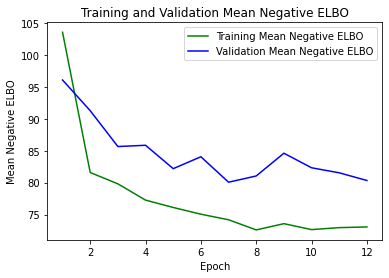

In [21]:
optimizer_gaussian = torch.optim.SGD(gaussian.parameters(), lr=1e-3)

def train_gaussian(num_epochs, patience=5):
    train_elbos = []
    val_elbos = []
    best_val_elbo = np.inf
    tolerance = 0
    epochs = num_epochs
    for epoch in tqdm(range(num_epochs)):
        overall_train_elbo = 0.0
        overall_val_elbo = 0.0
        for batch in train_dataloader_gauss:
            optimizer_gaussian.zero_grad()
            x, _ = batch
            x = x.to(DEVICE)
            x_left = x[:, :, :, :int(IMG_W / 2)]
            x_left = torch.flatten(x_left, start_dim=1)
            z, mu_z, log_var_z = gaussian(x_left)
            probs_x = decoder(z)
            probs_x_squared = probs_x.view(probs_x.shape[0], IMG_H, IMG_W)
            probs_x_left = torch.flatten(probs_x_squared[:, :, :int(IMG_W / 2)], start_dim=1)
            log_p = -F.binary_cross_entropy(probs_x_left, x_left, reduction='sum')
            kl = -0.5 * torch.sum(1 + log_var_z - mu_z.pow(2) - log_var_z.exp())
            negative_elbo = -log_p + kl
            negative_elbo.backward()
            optimizer_gaussian.step()
            overall_train_elbo += negative_elbo.item()

        for batch in val_dataloader_gauss:
            x, _ = batch
            x = x.to(DEVICE)
            with torch.no_grad():
                x_left = x[:, :, :, :int(IMG_W / 2)]
                x_left = torch.flatten(x_left, start_dim=1)
                z, mu_z, log_var_z = gaussian(x_left)
                probs_x = decoder(z)
                probs_x_squared = probs_x.view(probs_x.shape[0], IMG_H, IMG_W)
                probs_x_left = torch.flatten(probs_x_squared[:, :, :int(IMG_W / 2)], start_dim=1)
                log_p = -F.binary_cross_entropy(probs_x_left, x_left, reduction='sum')
                kl = -0.5 * torch.sum(1 + log_var_z - mu_z.pow(2) - log_var_z.exp())
                negative_elbo = -log_p + kl
                overall_val_elbo += negative_elbo.item()
        mean_train_elbo = overall_train_elbo / 400
        mean_val_elbo = overall_val_elbo / 100
        print('Epoch {}, Mean Training ELBO {}, Mean Validation ELBO {}'.format(epoch + 1, mean_train_elbo, mean_val_elbo))
        train_elbos.append(mean_train_elbo)
        val_elbos.append(mean_val_elbo)
        if mean_val_elbo < best_val_elbo:
            best_val_elbo = mean_val_elbo
            tolerance = 0
        else:
            tolerance += 1
            if tolerance == patience:
                print('Early Stopped!')
                epochs = epoch + 1
                break
    plt.plot(range(1, epochs + 1), train_elbos, 'g', label='Training Mean Negative ELBO')
    plt.plot(range(1, epochs + 1), val_elbos, 'b', label='Validation Mean Negative ELBO')
    plt.title('Training and Validation Mean Negative ELBO')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Negative ELBO')
    plt.legend()
    plt.show()
train_gaussian(num_epochs=20)

In [26]:
def test_image_completion():
    x, _ = next(iter(test_dataloader_gauss))
    x = x.to(DEVICE)
    with torch.no_grad():
        x_left = x[:, :, :, :int(IMG_W / 2)]
        x_left = torch.flatten(x_left, start_dim=1)
        z, _, _ = gaussian(x_left)
        probs_x = decoder(z)
        probs_x = probs_x.view(probs_x.shape[0], IMG_H, IMG_W)
        x_right_recon = probs_x[:, :, int(IMG_W / 2):]
        return x, x_right_recon
test_batch_ic, test_batch_ic_right_recon = test_image_completion()

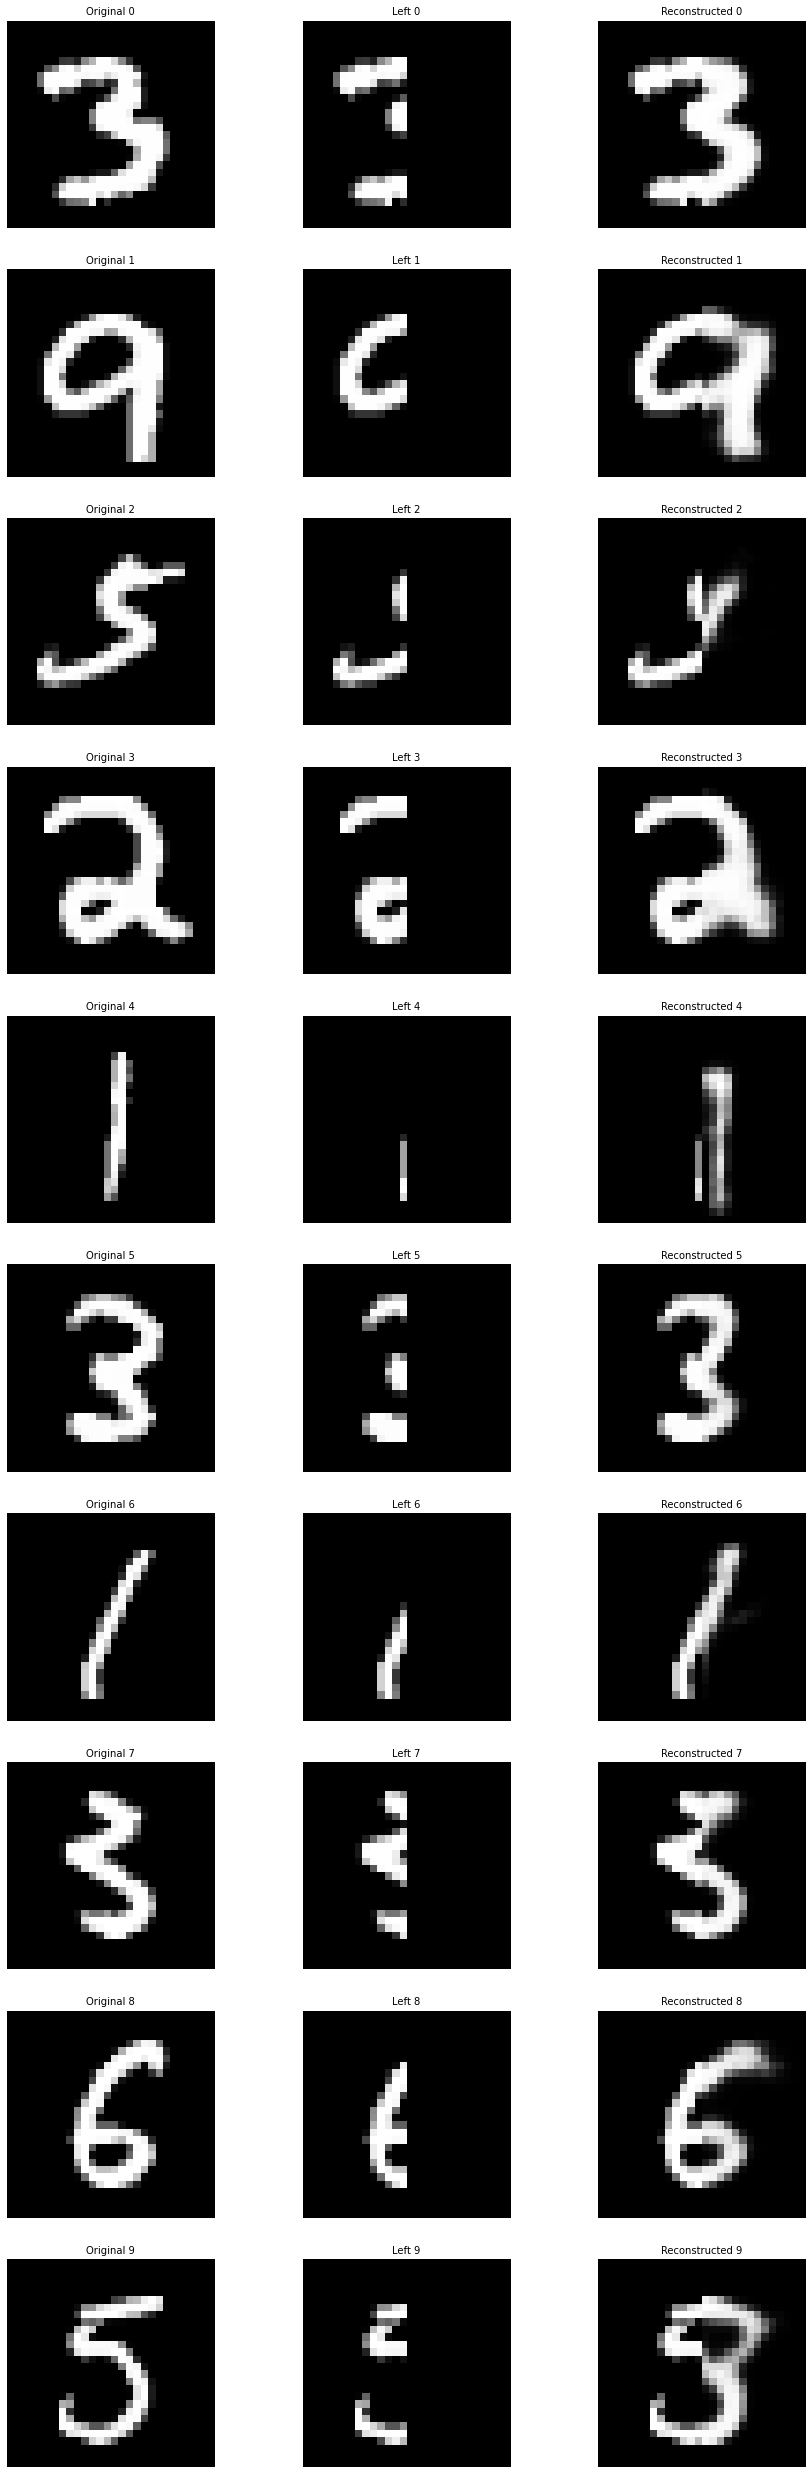

In [34]:
def show_image_completion(x, x_right_recon):
    """ plots first 32 images and reconstructions"""
    x = x.view(BATCH_SIZE, IMG_H, IMG_W)
    x_left = x[:, :, :int(IMG_W / 2)]
    x_right_covered = torch.zeros_like(x_left)
    x_covered = torch.cat((x_left, x_right_covered), dim=-1)
    x_right_recon = x_right_recon.view(BATCH_SIZE, IMG_H, int(IMG_W / 2))
    x_recon = torch.cat((x_left, x_right_recon), dim=-1)
    fig, ax = plt.subplots(10, 3, figsize=(15, 45))
    for i in range(10):
        ax[i][0].imshow(x[i].cpu().numpy(), cmap="Greys_r")
        ax[i][1].imshow(x_covered[i].cpu().numpy(), cmap="Greys_r")
        ax[i][2].imshow(x_recon[i].cpu().numpy(), cmap="Greys_r")
        ax[i][0].set_title(f"Original {i}", fontsize=10)
        ax[i][1].set_title(f"Left {i}", fontsize=10)
        ax[i][2].set_title(f"Reconstructed {i}", fontsize=10)
        ax[i][0].axis('off')
        ax[i][1].axis('off')
        ax[i][2].axis('off')
show_image_completion(test_batch_ic, test_batch_ic_right_recon)